<small><font color=gray>Notebook authors: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, Kiryll Bykov, Alexey Boldyrev ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🪐Venus vs Mars</font>](https://www.kaggle.com/competitions/19feb24hse-venusmars/rules)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

<small>**CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes.

At first take kaggle.json from https://www.kaggle.com/settings/account "Create New Token"

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
pip install -U kaggle  # upgrade kaggle package (to avoid a warning)

In [ ]:
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# !cp kaggle.json ~/.kaggle/kaggle.json           # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 19feb24hse-venusmars # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download                     # download competition dataset as a zip file
!unzip -o *.zip                                   # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

- competition is now set to: 19feb24hse-venusmars
Using competition: 19feb24hse-venusmars
19feb24hse-venusmars.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  19feb24hse-venusmars.zip
caution: filename not matched:  dataset2.zip
Using competition: 19feb24hse-venusmars
  teamId  teamName             submissionDate       score    
--------  -------------------  -------------------  -------  
11722244  Maxim Smeyanov       2024-03-10 13:34:07  0.95080  
11718851  AI                   2024-03-10 09:02:47  0.94760  
11711979  AO                   2024-03-10 13:28:51  0.93280  
11658960  A                    2024-03-10 18:21:59  0.92600  
11704074  AP                   2024-03-10 16:07:27  0.91800  
11661818  R                    2024-03-10 16:41:33  0.91760  
11726018  Ilshat Dineev        2024-03-10 17:23:52  0.90160  
11726366  Z                    2024-03-07 14:43:45  0.88360  
11691797  W                    2024-02-29 15:41:49  0.87200  


See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15101 MiB, 0 MiB


In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
from torch.utils.data import random_split
import torch, torchvision
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Sequential, Flatten, Linear, LazyLinear, Dropout, AdaptiveAvgPool2d, MaxPool2d, Conv2d, AvgPool2d
import torchvision
from torchvision.models import resnet50, mobilenet_v2, mobilenet_v3_small
from torchvision.datasets import ImageFolder
import torchvision.transforms as v2
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'train/', 'test/'

CPU times: user 4.5 s, sys: 701 ms, total: 5.2 s
Wall time: 10.5 s


Examples of images from female class

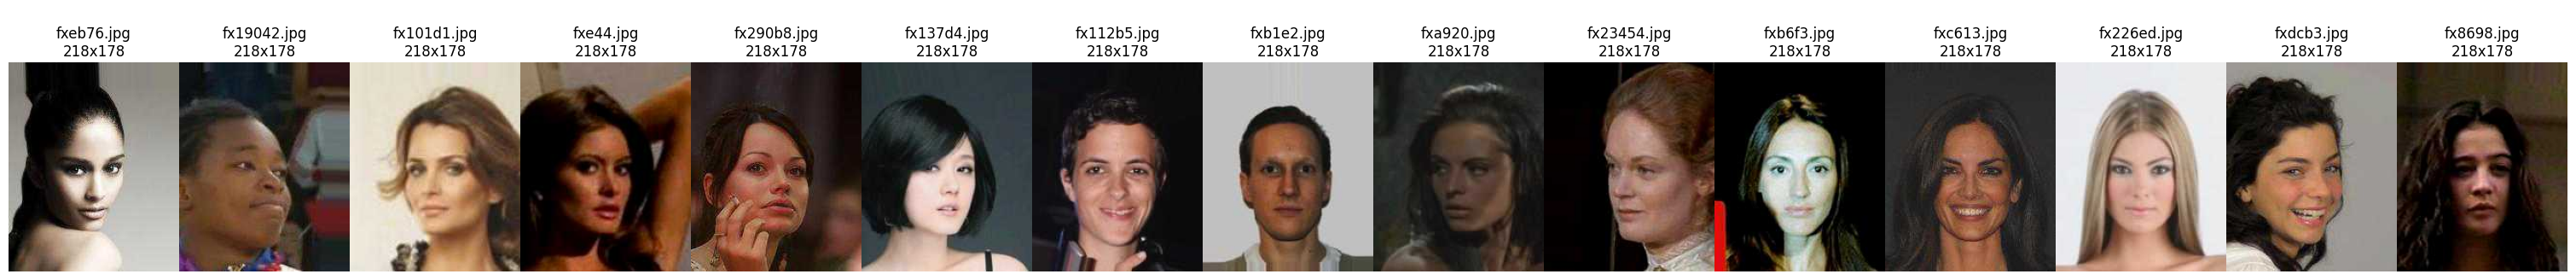

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'female/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'female/'+f);
  _ = ax.set_title(f'\n{f}\n{img.shape[0]}x{img.shape[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

Examples of images from male class

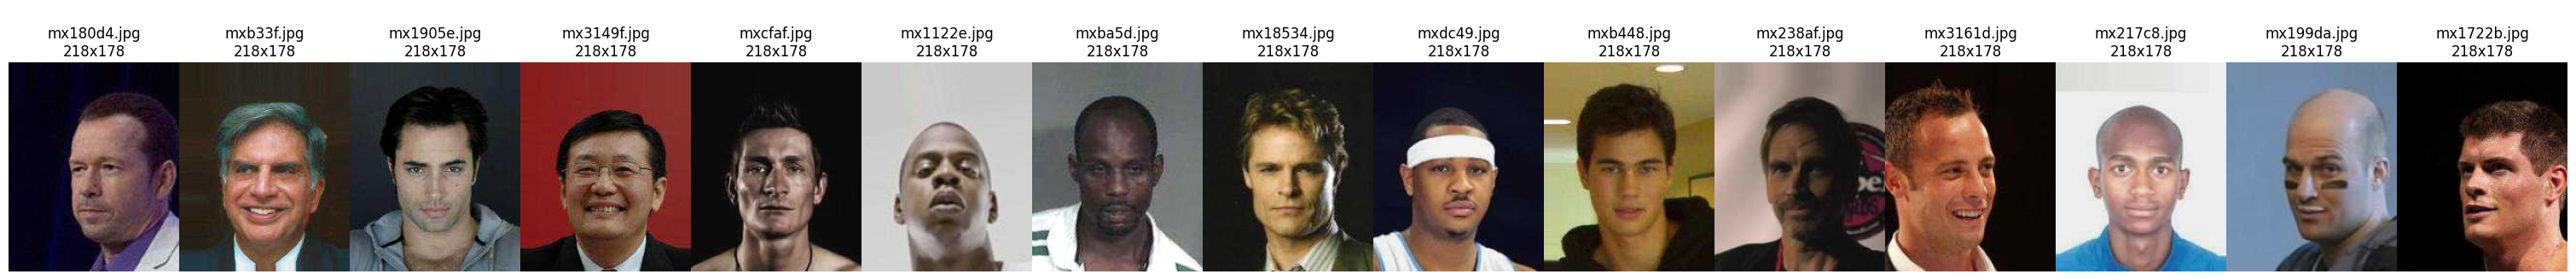

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'male/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'male/'+f);
  _ = ax.set_title(f'\n{f}\n{img.shape[0]}x{img.shape[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>


## **Task 2.1**

**Explain your preprocessing:** i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.

It haven't been tried.

## **Task 2.2**

**Explain your modeling approach:** ideas you tried and why you thought they would be helpful. Takeaway: how these decisions guided you in modeling.

The parameters of original model have been changed. In process we have seen that good parameters were epoch=4, learning rate = 0.5, gamma = 0.5. However, it wasn't enough to change parameters to improve the model. It is the same with the model layers, gradient and so on. Thus, it was decided to change the model to "resnet50" of torchvision library of models. And it has significantly improved our score. However, the same parameters were not good, thus we started playing with them again and decided to leave the same ones as starter ones.

The following cell loads train/validation/test sets as [ImageFolder datasets](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html), `tDS`, `vDS` and `sDS`, respectively.

In [ ]:
BS, image_size = 32, (224, 224)
transform = v2.Compose([v2.ToTensor(), v2.Resize(image_size, antialias=True)])

In [ ]:
!mv test/ labels/ && mkdir test && mv labels/ test/labels/

In [ ]:
im_folder_train = ImageFolder(tDIR, transform=transform)
im_folder_test = ImageFolder(sDIR, transform=transform)

In [ ]:
tDS, vDS = random_split(im_folder_train, lengths=[0.8, 0.2])

In [ ]:
tDL = DataLoader(tDS, batch_size=BS, shuffle=True, pin_memory=True)
vDL = DataLoader(vDS, batch_size=BS, shuffle=False, pin_memory=True)
sDL = DataLoader(im_folder_test, batch_size=BS, shuffle=False, pin_memory=True)

In [ ]:
print(f"Train size: {len(tDS)}")
print(f"Val size: {len(vDS)}")
print(f"Test size: {len(sDL)}")
print(next(iter(tDL))[0][:10].sum())  # to validate seeding of file sampling

Train size: 4000
Val size: 1000
Test size: 157
tensor(496284.4375)


This is your baseline DNN model. Remember to [seed all your experiments](https://pytorch.org/docs/stable/notes/randomness.html#reproducibility) for reproducibility.

Below we replace the top layer of the pretrained CNN ([MobileNetV2](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf)) and train the new layer only (all remaining pretrained layers are frozen).

In [ ]:
%%time
torch.manual_seed(0)  # always seed your experiments
torch.cuda.manual_seed_all(0)  # seed all that you can

CPU times: user 1.34 ms, sys: 40 µs, total: 1.38 ms
Wall time: 1.74 ms


In [ ]:
pm = mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2)  # pretrained mobile_net model

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
rn50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
pm1 = torch.nn.Sequential(
    rn50,
    LazyLinear(1)
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
for l in pm1[0].parameters(): l.requires_grad = False  # freeze layers from training
sgd = torch.optim.SGD(pm1.parameters(), lr=0.2, momentum=0.9, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(sgd, gamma=0.01)
criterion = nn.BCEWithLogitsLoss()
pm1 = pm1.to(device)

In [ ]:
def trainer(model, epoch=2, validate=True):
  losses = []

  for e in range(epoch):
    print(f"Epoch: {e}")
    model.train()
    for i, (image, label) in enumerate(tDL):


      image = image.to(device)
      label = label.to(device).type(torch.float32)
      sgd.zero_grad()
      pred = model(image)
      loss = criterion(pred, label.unsqueeze(1))
      losses.append(loss)

      # if i % 10 == 0:
        # print(loss)

      loss.backward()
      sgd.step()
      scheduler.step()

    if validate:
      model.eval()

      s = 0
      for i, (image, label) in enumerate(vDL):
        image = image.to(device)
        label = label.to(device).type(torch.float32)
        with torch.no_grad():
          val_preds = nn.functional.sigmoid(model(image))
          s += ((val_preds > 0.5).type(torch.int) == label.unsqueeze(1)).sum()

      print(f"Acc: {s / len(vDL)}")

  return losses

In [ ]:
%%time
hist = trainer(pm1)

Epoch: 0
Acc: 22.84375
Epoch: 1


Below we post-train all pre-trained layers after unlocking them.

In [ ]:
for l in pm1[0].parameters(): l.requires_grad = False  # freeze layers from training
sgd = torch.optim.SGD(pm1.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(sgd, gamma=0.001)

In [ ]:
%%time
hist_trainable = trainer(pm1)

Epoch: 0
Acc: 22.625
Epoch: 1
Acc: 22.71875
CPU times: user 30 s, sys: 3.5 s, total: 33.5 s
Wall time: 36.7 s


Compile and export predictions:

In [ ]:
vIDs = [f[0].split('/')[-1].split('.')[0] for f in sDL.dataset.imgs] # parse image IDs from file names

In [ ]:
with torch.no_grad():
    preds = []
    for img, _ in sDL:
        preds.append(nn.functional.sigmoid(pm1(img.to(device))).cpu().numpy().flatten())

In [ ]:
pY = pd.DataFrame(np.concatenate(preds, axis=0), index=vIDs, columns=['y'])   # predicted targets
ToCSV((pY>0.5)*1, '🪐-baseline')

# **References:**

- https://www.kaggle.com/code/gxkok21/resnet50-with-pytorch
- https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
- https://pytorch.org/vision/stable/models.html
- https://haochen23.github.io/2019/04/pre-trained-models-pytorch-keras.html#Let's-try-out-resnet50-and-resnet101.
- https://pytorch.org/docs/stable/data.html
- https://habr.com/ru/sandbox/163891/
- https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/MobileNet
- https://keras.io/guides/
- https://www.kaggle.com/docs/api
- https://pytorch.org/docs/stable/index.html
- https://pypi.org/project/torch-summary/
- https://ipython.readthedocs.io/en/stable/api/generated/IPython.core.interactiveshell.html
- https://app.datacamp.com/learn/courses/bayesian-data-analysis-in-python
- https://app.datacamp.com/learn/courses/introduction-to-deep-learning-with-pytorch

<font size=5>⏳</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 131 sec


## 💡**Starter Ideas**

1. Try tuning CNN hyperparameters and architecture
1. Other [pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) can be faster or more accurate for the given dataset and/or hardware ([benchmarks](https://datascience.stackexchange.com/a/39211/14094))
1. Transforming images via [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)could be faster
1. Identify poorly predicted train images (with near-boundary confidence) and add their augmented versions
1. Identify poorly predicted test images (with near-boundary confidence) and post-train CNN even more on "similar" train images. Similarity can be done in terms of some of the layer(s) of CNN
1. Do you really need all given images? CNN will train faster on a "meaningful" subsample
1. Try ensembling different pretrained CNNs or only their selected layers
1. Try different learning rate for different layers of pretrained models
1. Try cropping instead of resizing images to the fixed $224\times224$ (faces look more naturally if aspect ratio is respected)
1. Try [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit) in Colab. 😮 See [doc example](https://www.tensorflow.org/guide/tpu). Local images should be loaded with [Python I/O](https://stackoverflow.com/a/63147614/3043335), not TF datasets.